In [1]:
%matplotlib inline
import torch as tc
import tensorflow as tf
import mxnet as mx
from mxnet import np as mxnp
from mxnet import npx as npx
npx.set_np()
# import numpy as np

from d2l import mxnet as mxd2l  # Use MXNet as the backend
from d2l import torch as tcd2l  # Use PyTorch as the backend
from d2l import tensorflow as tfd2l  # Use TensorFlow as the backend

tc.__version__,tf.__version__,mx.__version__

('1.6.0', '2.3.1', '1.7.0')

## MX

In [2]:
from mxnet.gluon import nn
def vgg_block_mx(num_conv_layers,num_channels):
    blk=nn.Sequential()
    for _ in range(num_conv_layers):
        blk.add(nn.Conv2D(num_channels,kernel_size=3,padding=1,activation='relu'))
    blk.add(nn.MaxPool2D(pool_size=2,strides=2))
    return blk   

In [61]:
vgg_net_block=vgg_block_mx(3,10)
vgg_net_block

Sequential(
  (0): Conv2D(-1 -> 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
  (1): Conv2D(-1 -> 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
  (2): Conv2D(-1 -> 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
  (3): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
)

In [3]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
def vgg_mx(conv_arch):
    net=nn.Sequential()
    for num_conv_layers,num_channels in conv_arch:
        net.add(vgg_block_mx(num_conv_layers,num_channels))
    net.add(nn.Dense(4096,activation='relu'),nn.Dropout(0.5),
            nn.Dense(4096,activation='relu'),nn.Dropout(0.5),
            nn.Dense(10)
           )
    return net

In [64]:
vnet_mx=vgg_mx(conv_arch)
vnet_mx

Sequential(
  (0): Sequential(
    (0): Conv2D(-1 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  )
  (1): Sequential(
    (0): Conv2D(-1 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (1): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  )
  (2): Sequential(
    (0): Conv2D(-1 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (1): Conv2D(-1 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (2): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  )
  (3): Sequential(
    (0): Conv2D(-1 -> 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), Activation(relu))
    (1): Conv2D(-1 -> 512, kernel_size=(

loss 0.172, train acc 0.937, test acc 0.923
643.8 examples/sec on gpu(0)


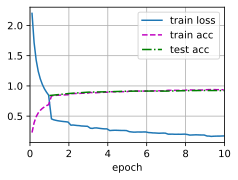

In [5]:
lr, num_epochs, batch_size = 0.05, 10, 256
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
small_conv_arch,conv_arch

train_iter, test_iter = mxd2l.load_data_fashion_mnist(batch_size, resize=224)
net=vgg_mx(small_conv_arch)
mxd2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

## TC

In [2]:
from torch import nn
def vgg_block_tc(num_conv_layers,in_channels,out_channels):
    layers=[]
    for _ in range(num_conv_layers):
        layers.append(nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1))
        layers.append(nn.ReLU())
        in_channels=out_channels
    layers.append(nn.MaxPool2d(kernel_size=2,stride=2))
    return nn.Sequential(*layers)

In [71]:
vgg_net_block=vgg_block_tc(3,5,10)
vgg_net_block

Sequential(
  (0): Conv2d(5, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU()
  (4): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (5): ReLU()
  (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [3]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
def vgg_tc(conv_arch,in_channels=1):
    sequential_blocks=[]
    for num_conv_layers,out_channels in conv_arch:
        sequential_block=vgg_block_tc(num_conv_layers,in_channels,out_channels)
        in_channels=out_channels
        sequential_blocks.append(sequential_block)
    dense_blocks=[nn.Flatten(),
                  nn.Linear(out_channels*7*7,4096),nn.ReLU(),nn.Dropout(),
                  nn.Linear(4096,4096),nn.ReLU(),nn.Dropout(),
                  nn.Linear(4096,10)]
    blocks=sequential_blocks+dense_blocks
       
    return nn.Sequential(*blocks)         

In [84]:
vnet_tc=vgg_tc(conv_arch)
vnet_tc

Sequential(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (4):

In [111]:
X = tc.randn(size=(1, 3, 224, 224))
for blk in vgg_tc(conv_arch,in_channels=3):
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [112]:
X = tc.randn(size=(1, 1, 224, 224))
for blk in vgg_tc(conv_arch,in_channels=1):
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t',X.shape)

Sequential output shape:	 torch.Size([1, 64, 112, 112])
Sequential output shape:	 torch.Size([1, 128, 56, 56])
Sequential output shape:	 torch.Size([1, 256, 28, 28])
Sequential output shape:	 torch.Size([1, 512, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
Flatten output shape:	 torch.Size([1, 25088])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 4096])
ReLU output shape:	 torch.Size([1, 4096])
Dropout output shape:	 torch.Size([1, 4096])
Linear output shape:	 torch.Size([1, 10])


In [113]:
v=vgg_tc(conv_arch,in_channels=3)
v[0][0].weight.shape

torch.Size([64, 3, 3, 3])

In [114]:
v=vgg_tc(conv_arch,in_channels=1)
v[0][0].weight.shape

torch.Size([64, 1, 3, 3])

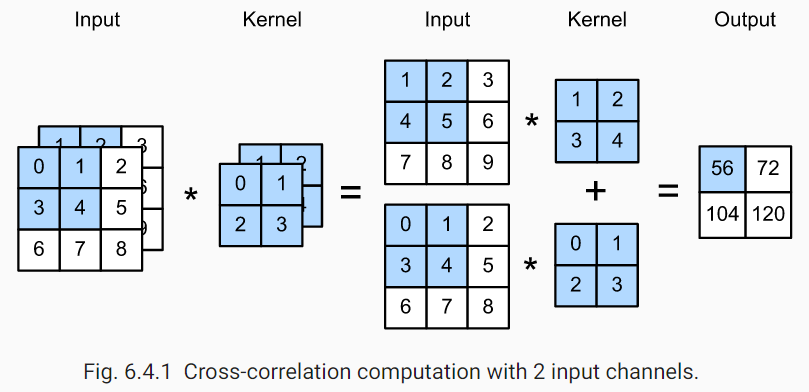

In [115]:
# help(nn.Conv2d)

In [4]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
small_conv_arch,conv_arch

([(1, 16), (1, 32), (2, 64), (2, 128), (2, 128)],
 ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512)))

loss 0.256, train acc 0.904, test acc 0.896
836.7 examples/sec on cuda:0


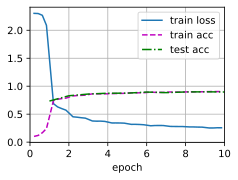

In [5]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = tcd2l.load_data_fashion_mnist(batch_size, resize=224)
net=vgg_tc(small_conv_arch)
tcd2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)

## TF

In [2]:
import tensorflow as tf
def vgg_block_tf(num_conv_layers,num_channels):
    blk=tf.keras.models.Sequential()
    for _ in range(num_conv_layers):
        blk.add(tf.keras.layers.Conv2D(filters=num_channels,kernel_size=3,padding='same',activation='relu'))
    blk.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=2))
    return blk
def vgg_tf(conv_arch):
    net=tf.keras.models.Sequential()
    for num_conv_layers,num_channels in conv_arch:
        net.add(vgg_block_tf(num_conv_layers,num_channels))
    net.add(tf.keras.layers.Flatten())
    net.add(tf.keras.layers.Dense(4096,activation='relu'))
    net.add(tf.keras.layers.Dropout(0.5))
    net.add(tf.keras.layers.Dense(4096,activation='relu'))
    net.add(tf.keras.layers.Dropout(0.5))
    net.add(tf.keras.layers.Dense(10))
    return net      
    

In [4]:
vgg_net_block=vgg_block_tf(3,10)

In [5]:
# vgg_net_block??

In [6]:
input_shape=(1,3,28,28)

In [7]:
vgg_net_block.build(input_shape)

In [8]:
vgg_net_block.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (1, 3, 28, 10)            2530      
_________________________________________________________________
conv2d_1 (Conv2D)            (1, 3, 28, 10)            910       
_________________________________________________________________
conv2d_2 (Conv2D)            (1, 3, 28, 10)            910       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (1, 1, 14, 10)            0         
Total params: 4,350
Trainable params: 4,350
Non-trainable params: 0
_________________________________________________________________


In [9]:
for  l in vgg_net_block.layers:
    if isinstance(l,tf.keras.layers.Conv2D):
        tf.print(l.name,l.kernel_size,l.strides,l.padding,l.activation.__name__)
    if isinstance(l,tf.keras.layers.MaxPool2D):
        tf.print(l.name,l.pool_size,l.strides)

conv2d (3, 3) (1, 1) same relu
conv2d_1 (3, 3) (1, 1) same relu
conv2d_2 (3, 3) (1, 1) same relu
max_pooling2d (2, 2) (2, 2)


In [3]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [19]:
vnet_tf=vgg_tf(conv_arch)

In [21]:
vnet_tf1=vgg_tf(conv_arch)
X = tf.random.uniform((1, 224, 224, 3))
for blk in vnet_tf1.layers:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 (1, 112, 112, 64)
Sequential output shape:	 (1, 56, 56, 128)
Sequential output shape:	 (1, 28, 28, 256)
Sequential output shape:	 (1, 14, 14, 512)
Sequential output shape:	 (1, 7, 7, 512)
Flatten output shape:	 (1, 25088)
Dense output shape:	 (1, 4096)
Dropout output shape:	 (1, 4096)
Dense output shape:	 (1, 4096)
Dropout output shape:	 (1, 4096)
Dense output shape:	 (1, 10)


In [23]:
vnet_tf2=vgg_tf(conv_arch)
X = tf.random.uniform((1, 224, 224, 1))
for blk in vnet_tf2.layers:
    X = blk(X)
    print(blk.__class__.__name__,'output shape:\t', X.shape)

Sequential output shape:	 (1, 112, 112, 64)
Sequential output shape:	 (1, 56, 56, 128)
Sequential output shape:	 (1, 28, 28, 256)
Sequential output shape:	 (1, 14, 14, 512)
Sequential output shape:	 (1, 7, 7, 512)
Flatten output shape:	 (1, 25088)
Dense output shape:	 (1, 4096)
Dropout output shape:	 (1, 4096)
Dense output shape:	 (1, 4096)
Dropout output shape:	 (1, 4096)
Dense output shape:	 (1, 10)


In [3]:
conv_arch = ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]
small_conv_arch,conv_arch

([(1, 16), (1, 32), (2, 64), (2, 128), (2, 128)],
 ((1, 64), (1, 128), (2, 256), (2, 512), (2, 512)))

loss 0.173, train acc 0.936, test acc 0.918
1014.2 examples/sec on /GPU:0


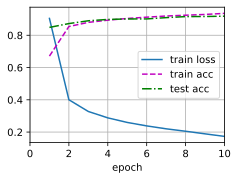

In [5]:
lr, num_epochs, batch_size = 0.05, 10, 128
train_iter, test_iter = tfd2l.load_data_fashion_mnist(batch_size, resize=224)
net=lambda:vgg_tf(small_conv_arch)
tfd2l.train_ch6(net, train_iter, test_iter, num_epochs, lr)
# loss 0.231, train acc 0.915, test acc 0.910
# 995.3 examples/sec on /GPU:0
# when batch_size=256

In [ ]:
!nvidia-smi

In [6]:
ratio = 4
small_conv_arch = [(pair[0], pair[1] // ratio) for pair in conv_arch]

In [7]:
conv_arch

((1, 64), (1, 128), (2, 256), (2, 512), (2, 512))

In [8]:
small_conv_arch

[(1, 16), (1, 32), (2, 64), (2, 128), (2, 128)]

In [7]:
tfd2l.predict_ch3(test_iter)

TypeError: predict_ch3() missing 1 required positional argument: 'test_iter'

Signature:
tfd2l.train_ch6(
    net_fn,
    train_iter,
    test_iter,
    num_epochs,
    lr,
    device=<tensorflow.python.eager.context._EagerDeviceContext object at 0x000002627F18EA60>,
)
Source:   
def train_ch6(net_fn, train_iter, test_iter, num_epochs, lr,
              device=d2l.try_gpu()):
    """Train a model with a GPU (defined in Chapter 6)."""
    device_name = device._device_name
    strategy = tf.distribute.OneDeviceStrategy(device_name)
    with strategy.scope():
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        net = net_fn()
        net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    callback = TrainCallback(net, train_iter, test_iter, num_epochs,
                             device_name)
    net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[callback])
    return net
File:      c:\users\hp\miniconda3\envs\d2l\lib\site-packages\d2l\tensorflow